# Major Leagues

a project for EECS 731 by Benjamin Wyss

Examining fivethirtyeight soccer power index (spi) data sets to build a regression model which predicts the scores of soccer matches

###### python imports

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### Reading Data Sets From CSV

fivethirtyeight Soccer SPI Ratings and Matches

Taken from: https://github.com/fivethirtyeight/data/tree/master/soccer-spi on 10/1/20

Only the spi_matches dataset is examined because it contains all of the match information and historical spi data needed to build the target regression model. The spi_matches_latest data set is a subset of the spi_matches dataset, and thus it can be discarded without losing any additional match data samples. The remaining data sets include information about current spi ratings, but the target regression model should perform better at predicting match scores based on ratings from when a match occured rather than from current ratings, so these data sets are discarded as well.

###### Soccer Matches and SPI Ratings Data Set

In [2]:
df = pd.read_csv('../data/raw/spi_matches.csv')

In [3]:
df

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2016,2016-07-09,7921,FA Women's Super League,Liverpool Women,Reading,51.56,50.42,0.4389,0.2767,...,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,2016-07-10,7921,FA Women's Super League,Arsenal Women,Notts County Ladies,46.61,54.03,0.3572,0.3608,...,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,2016-07-10,7921,FA Women's Super League,Chelsea FC Women,Birmingham City,59.85,54.64,0.4799,0.2487,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,2016-07-16,7921,FA Women's Super League,Liverpool Women,Notts County Ladies,53.00,52.35,0.4289,0.2699,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,2016-07-17,7921,FA Women's Super League,Chelsea FC Women,Arsenal Women,59.43,60.99,0.4124,0.3157,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42168,2020,2021-05-30,1871,Spanish Segunda Division,Mirandes,CD Sabadell,32.09,30.30,0.4473,0.2862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42169,2020,2021-05-30,1871,Spanish Segunda Division,AD Alcorcon,Espanyol,33.41,62.03,0.1738,0.5834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42170,2020,2021-05-30,1871,Spanish Segunda Division,Málaga,Castellon,35.64,31.26,0.4759,0.2216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42171,2020,2021-05-30,1871,Spanish Segunda Division,FC Cartagena,Girona FC,29.81,39.15,0.3196,0.3964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The Big Ideas

Feature engineering and transformation can add value to this data set for building a regression model in the following ways:

(1): By selecting only the most promising and score-correlated attributes as input features, the target regression model will be able to best utilize correlations between features and match scores to increase overall model accuracy.

(2): By one-hot encoding league and team names, the target regression model can gain additional information about how many points specific teams score throughout specific leagues which will aid its prediction accuracy.

(3): By standardizing season years and spi scores to values between 0 and 1, the target regression model will perform better because the range of input feature values will be reduced. This prevents the season year feature, which has values in the thousands, from dominating over the spi score features, which have values in the tens.

## Exploratory Data Analysis

### Cleaning the Data Set

First, only the most relevant and easy to understand columns are selected. I select season years, league, teams, spi scores, and match scores. Different teams should perform differently in different seasons and leagues, so those features are included. Additionally, spi score should be a very good predictor of match score because it reflects overall team performance, thus the spi score features are included as well.

Next, rows with NaN score values are dropped from the data set because these rows correspond to matches that have either yet to happen or matches that have no score data. The target regression model cannot train on these rows, but they can be saved for the final regression model to make predictions on their scores.

In [4]:
df = df[['season', 'league', 'team1', 'team2', 'spi1', 'spi2', 'score1', 'score2']]

In [5]:
df

,season,league,team1,team2,spi1,spi2,score1,score2
0,2016,FA Women's Super League,Liverpool Women,Reading,51.56,50.42,2.0,0.0
1,2016,FA Women's Super League,Arsenal Women,Notts County Ladies,46.61,54.03,2.0,0.0
2,2016,FA Women's Super League,Chelsea FC Women,Birmingham City,59.85,54.64,1.0,1.0
3,2016,FA Women's Super League,Liverpool Women,Notts County Ladies,53.00,52.35,0.0,0.0
4,2016,FA Women's Super League,Chelsea FC Women,Arsenal Women,59.43,60.99,1.0,2.0
...,...,...,...,...,...,...,...,...
42168,2020,Spanish Segunda Division,Mirandes,CD Sabadell,32.09,30.30,NaN,NaN
42169,2020,Spanish Segunda Division,AD Alcorcon,Espanyol,33.41,62.03,NaN,NaN
42170,2020,Spanish Segunda Division,Málaga,Castellon,35.64,31.26,NaN,NaN
42171,2020,Spanish Segunda Division,FC Cartagena,Girona FC,29.81,39.15,NaN,NaN


In [6]:
futureGames = df
df = df.dropna()
futureGames = futureGames[~futureGames.isin(df).all(1)]

In [7]:
df

,season,league,team1,team2,spi1,spi2,score1,score2
0,2016,FA Women's Super League,Liverpool Women,Reading,51.56,50.42,2.0,0.0
1,2016,FA Women's Super League,Arsenal Women,Notts County Ladies,46.61,54.03,2.0,0.0
2,2016,FA Women's Super League,Chelsea FC Women,Birmingham City,59.85,54.64,1.0,1.0
3,2016,FA Women's Super League,Liverpool Women,Notts County Ladies,53.00,52.35,0.0,0.0
4,2016,FA Women's Super League,Chelsea FC Women,Arsenal Women,59.43,60.99,1.0,2.0
...,...,...,...,...,...,...,...,...
34851,2020,United Soccer League,Tacoma Defiance,Sacramento Republic FC,12.36,23.81,1.0,0.0
34852,2020,United Soccer League,Reno 1868 FC,Las Vegas Lights FC,31.04,12.87,2.0,2.0
34853,2020,Spanish Primera Division,Athletic Bilbao,Cadiz,68.91,63.74,0.0,1.0
34854,2020,Spanish Primera Division,Sevilla FC,Levante,80.51,67.72,1.0,0.0


In [8]:
futureGames

,season,league,team1,team2,spi1,spi2,score1,score2
26879,2019,Scottish Premiership,Rangers,St Johnstone,61.23,19.87,NaN,NaN
29061,2019,FA Women's Super League,Liverpool Women,Manchester United Women,40.26,56.87,NaN,NaN
29666,2019,FA Women's Super League,Liverpool Women,Birmingham City,40.26,47.79,NaN,NaN
29894,2019,FA Women's Super League,Birmingham City,Brighton & Hove Albion,47.79,48.48,NaN,NaN
29895,2019,FA Women's Super League,Bristol Academy,Reading,37.87,52.45,NaN,NaN
...,...,...,...,...,...,...,...,...
42168,2020,Spanish Segunda Division,Mirandes,CD Sabadell,32.09,30.30,NaN,NaN
42169,2020,Spanish Segunda Division,AD Alcorcon,Espanyol,33.41,62.03,NaN,NaN
42170,2020,Spanish Segunda Division,Málaga,Castellon,35.64,31.26,NaN,NaN
42171,2020,Spanish Segunda Division,FC Cartagena,Girona FC,29.81,39.15,NaN,NaN


### Transforming the data set

##### One-hot Encoding League and Team Names

Encoding these colums is necessary to transform textual data into numeric data which the target regression model can reason about. Additionally, one-hot encoding is selected over label encoding because label encoding will introduce arbitrary distances between different leagues and teams that can negatively influence the accuracy of the target regression model.

Once the one-hot encoded columns are generated, pandas automatically removes the original textual columns from the data set. This is good because they will not provide any value to the target regression model.

In [9]:
df = pd.get_dummies(df, columns=['league', 'team1', 'team2'])

In [10]:
df

,season,spi1,spi2,score1,score2,league_Argentina Primera Division,league_Australian A-League,league_Austrian T-Mobile Bundesliga,league_Barclays Premier League,league_Belgian Jupiler League,...,team2_Würzburger Kickers,team2_Yeni Malatyaspor,team2_Yeovil Town,team2_Yeovil Town Ladies,team2_Yokohama F. Marinos,team2_Yokohama FC,team2_Young Boys,team2_Zenit St Petersburg,team2_Zlín,team2_Östersunds FK
0,2016,51.56,50.42,2.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016,46.61,54.03,2.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016,59.85,54.64,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016,53.00,52.35,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016,59.43,60.99,1.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,2020,12.36,23.81,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34852,2020,31.04,12.87,2.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34853,2020,68.91,63.74,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34854,2020,80.51,67.72,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Standardizing Season Years and SPI Scores

The season year and spi score columns are standardized to values ranging from 0 to 1 so that the ranges and relative magnitudes of these values aren't overrepresented in the target regression model.

In [12]:
df['season'] = (df['season'] - 2016) / 4
df['spi1'] = df['spi1'] / 100
df['spi2'] = df['spi2'] / 100

In [13]:
df

,season,spi1,spi2,score1,score2,league_Argentina Primera Division,league_Australian A-League,league_Austrian T-Mobile Bundesliga,league_Barclays Premier League,league_Belgian Jupiler League,...,team2_Würzburger Kickers,team2_Yeni Malatyaspor,team2_Yeovil Town,team2_Yeovil Town Ladies,team2_Yokohama F. Marinos,team2_Yokohama FC,team2_Young Boys,team2_Zenit St Petersburg,team2_Zlín,team2_Östersunds FK
0,-504.00,0.005156,0.005042,2.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-504.00,0.004661,0.005403,2.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-504.00,0.005985,0.005464,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-504.00,0.005300,0.005235,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-504.00,0.005943,0.006099,1.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,-503.75,0.001236,0.002381,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34852,-503.75,0.003104,0.001287,2.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34853,-503.75,0.006891,0.006374,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34854,-503.75,0.008051,0.006772,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exporting Transformed Data Set to CSV

Note that this file is too large to upload to github, so it is not included in the repository

In [14]:
df.to_csv('../data/processed/matches_transformed.csv')

### Visualizing the Data

First, some basic statistics of the data set and correlation coefficients are calculated

In [13]:
df.describe()

,season,spi1,spi2,score1,score2,league_Argentina Primera Division,league_Australian A-League,league_Austrian T-Mobile Bundesliga,league_Barclays Premier League,league_Belgian Jupiler League,...,team2_Würzburger Kickers,team2_Yeni Malatyaspor,team2_Yeovil Town,team2_Yeovil Town Ladies,team2_Yokohama F. Marinos,team2_Yokohama FC,team2_Young Boys,team2_Zenit St Petersburg,team2_Zlín,team2_Östersunds FK
count,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,...,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000,34268.000000
mean,0.514686,0.449694,0.449256,1.523112,1.181715,0.028569,0.008404,0.017159,0.045173,0.016488,...,0.000029,0.001547,0.000671,0.000525,0.001021,0.000292,0.001868,0.001838,0.000088,0.001751
std,0.252597,0.188628,0.188876,1.282570,1.142430,0.166594,0.091290,0.129865,0.207687,0.127343,...,0.005402,0.039297,0.025899,0.022913,0.031943,0.017080,0.043176,0.042838,0.009356,0.041808
min,0.000000,0.038800,0.040400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.312200,0.312100,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.429200,0.428050,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.750000,0.581000,0.580600,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.965700,0.967800,11.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
df.corr()

,season,spi1,spi2,score1,score2,league_Argentina Primera Division,league_Australian A-League,league_Austrian T-Mobile Bundesliga,league_Barclays Premier League,league_Belgian Jupiler League,...,team2_Würzburger Kickers,team2_Yeni Malatyaspor,team2_Yeovil Town,team2_Yeovil Town Ladies,team2_Yokohama F. Marinos,team2_Yokohama FC,team2_Young Boys,team2_Zenit St Petersburg,team2_Zlín,team2_Östersunds FK
season,1.000000,-0.228354,-0.229937,-0.011913,0.015250,-0.027654,0.041472,0.003661,-0.110549,0.073670,...,0.010379,0.000652,-0.001507,-0.011417,0.031596,0.032826,-0.001177,0.002899,-0.009805,0.010000
spi1,-0.228354,1.000000,0.717255,0.145003,-0.077101,-0.000819,-0.063018,-0.009184,0.279675,0.011651,...,0.001550,0.005389,-0.043399,0.007899,-0.017324,-0.007282,0.003724,0.021387,0.003159,-0.020006
spi2,-0.229937,0.717255,1.000000,-0.080582,0.128151,-0.001447,-0.063891,-0.009927,0.279323,0.009659,...,-0.005934,-0.003762,-0.049742,-0.010039,-0.003111,-0.025854,0.053068,0.061003,-0.001136,-0.017252
score1,-0.011913,0.145003,-0.080582,1.000000,-0.055018,-0.034708,0.005818,0.006204,0.004954,0.007762,...,-0.002203,0.003054,-0.002663,0.029378,-0.002357,0.005021,-0.006049,-0.021222,0.005911,-0.005109
score2,0.015250,-0.077101,0.128151,-0.055018,1.000000,-0.029118,0.019214,0.031895,0.007220,0.009294,...,-0.005588,-0.006910,-0.006095,-0.014795,0.012507,0.001769,0.023884,0.003907,-0.009679,-0.000552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
team2_Yokohama FC,0.032826,-0.007282,-0.025854,0.005021,0.001769,-0.002930,-0.001573,-0.002257,-0.003716,-0.002212,...,-0.000092,-0.000672,-0.000443,-0.000392,-0.000546,1.000000,-0.000739,-0.000733,-0.000160,-0.000716
team2_Young Boys,-0.001177,0.003724,0.053068,-0.006049,0.023884,-0.007418,-0.003982,-0.005715,-0.009409,-0.005601,...,-0.000234,-0.001702,-0.001121,-0.000992,-0.001383,-0.000739,1.000000,-0.001856,-0.000405,-0.001812
team2_Zenit St Petersburg,0.002899,0.021387,0.061003,-0.021222,0.003907,-0.007360,-0.003951,-0.005671,-0.009335,-0.005557,...,-0.000232,-0.001689,-0.001112,-0.000984,-0.001372,-0.000733,-0.001856,1.000000,-0.000402,-0.001797
team2_Zlín,-0.009805,0.003159,-0.001136,0.005911,-0.009679,-0.001605,-0.000861,-0.001236,-0.002035,-0.001212,...,-0.000051,-0.000368,-0.000242,-0.000215,-0.000299,-0.000160,-0.000405,-0.000402,1.000000,-0.000392


###### Generating Interesting Plots

<AxesSubplot:title={'center':'Team 1 SPI Score vs. Team 1 Match Score'}, xlabel='spi1', ylabel='score1'>

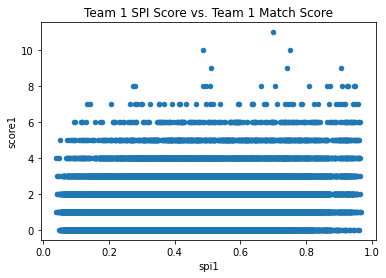

In [15]:
df.plot.scatter(x='spi1', y='score1', title='Team 1 SPI Score vs. Team 1 Match Score')

<AxesSubplot:title={'center':'Team 2 SPI Score vs. Team 2 Match Score'}, xlabel='spi2', ylabel='score2'>

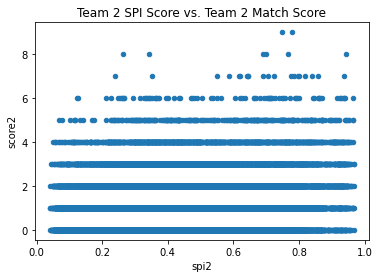

In [16]:
df.plot.scatter(x='spi2', y='score2', title='Team 2 SPI Score vs. Team 2 Match Score')

<AxesSubplot:title={'center':'Team 1 SPI Score vs. Team 2 Match Score'}, xlabel='spi1', ylabel='score2'>

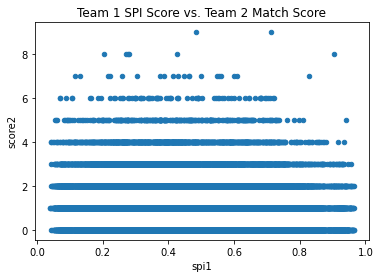

In [17]:
df.plot.scatter(x='spi1', y='score2', title='Team 1 SPI Score vs. Team 2 Match Score')

<AxesSubplot:title={'center':'Team 2 SPI Score vs. Team 1 Match Score'}, xlabel='spi2', ylabel='score1'>

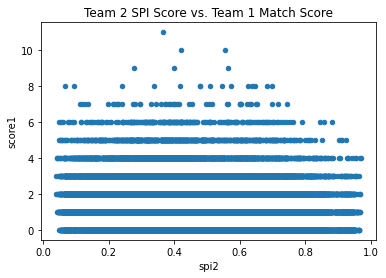

In [18]:
df.plot.scatter(x='spi2', y='score1', title='Team 2 SPI Score vs. Team 1 Match Score')

Now, visualize how the difference between two teams' spi scores affects their match scores

In [13]:
dfDiff = df[['spi1', 'spi2', 'score1', 'score2']]
dfDiff['spi1-spi2'] = dfDiff['spi1'] - dfDiff['spi2']

<AxesSubplot:title={'center':'Spi Score Difference vs. Team 1 Match Score'}, xlabel='spi1-spi2', ylabel='score1'>

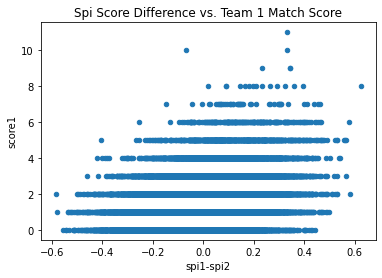

In [28]:
dfDiff.plot.scatter(x='spi1-spi2', y='score1', title='Spi Score Difference vs. Team 1 Match Score')

<AxesSubplot:title={'center':'Spi Score Difference vs. Team 2 Match Score'}, xlabel='spi1-spi2', ylabel='score2'>

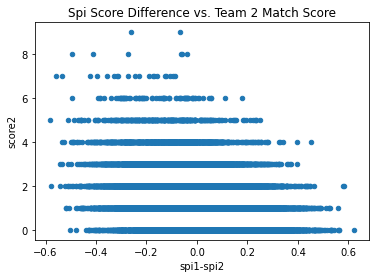

In [29]:
dfDiff.plot.scatter(x='spi1-spi2', y='score2', title='Spi Score Difference vs. Team 2 Match Score')

###### Intuitions Gained From Visualizations

While there does appear to be a small correlation between a team's spi score and their match score, a stronger correlation exists between the difference in two teams' spi scores and their match scores. This intuitively makes sense, and regression models which utilize spi score difference as an input feature will be tested.

There also appears to be large amounts of variance between spi scores and match scores, and this will likely limit the performance of the target regression model.

### Model Construction

A variety of machine learning regression models using a variety of input features will be tested and compared based on their coefficient of determination (r2_score).

First, the pandas dataframe is converted to numpy arrays of input features (X arrays) and output regression targets (Y arrays). I will test 3 different sets of input features--one set containing all of the engineered features, one set containing only spi scores, and one set containing only spi scores and the spi difference score. These different sets of features were selected to determine whether including information about leagues, seasons, teams, and spi score differences will aid or hinder the target regression model.

In [14]:
Y1 = df['score1'].values
Y2 = df['score2'].values

score1 = df.pop('score1')
score2 = df.pop('score2')
df['spidiff'] = dfDiff['spi1-spi2']

Xall = df.values
Xspi = df[['spi1', 'spi2']].values
Xdiff = df[['spi1', 'spi2', 'spidiff']].values

Split the data into 80% training data and 20% validation data. This split is chosen as to make overfitting less of an issue in the final regression model.

In [15]:
Xall_train1, Xall_validate1, Yall_train1, Yall_validate1 = train_test_split(Xall, Y1, test_size=0.2, shuffle=True)
Xall_train2, Xall_validate2, Yall_train2, Yall_validate2 = train_test_split(Xall, Y2, test_size=0.2, shuffle=True)

Xspi_train1, Xspi_validate1, Yspi_train1, Yspi_validate1 = train_test_split(Xspi, Y1, test_size=0.2, shuffle=True)
Xspi_train2, Xspi_validate2, Yspi_train2, Yspi_validate2 = train_test_split(Xspi, Y2, test_size=0.2, shuffle=True)

Xdiff_train1, Xdiff_validate1, Ydiff_train1, Ydiff_validate1 = train_test_split(Xdiff, Y1, test_size=0.2, shuffle=True)
Xdiff_train2, Xdiff_validate2, Ydiff_train2, Ydiff_validate2 = train_test_split(Xdiff, Y2, test_size=0.2, shuffle=True)

### Testing Different Models With 10-Fold Cross Validation

I will test LinearRegression, RandomForest, and Multi-LayerPerceptron (MLP Neural Network). These models were chosen so that a variety of approaches--classical, ensemble, and neural network--can be compared to determine best performing model and approach.

10-fold cross validation r2_score is selected as the scoring metric because 10-fold cross validation will reduce overfitting, and the target model should be the model with predictions most closely matching the test data.

#### Generating a k=10 kFold Object to Pass to Cross-Validation Functions

In [16]:
kFold = StratifiedKFold(n_splits=10, shuffle=True)

###### Linear Regression With Only SPI Scores

In [65]:
lr_spi_pred1 = cross_val_predict(LinearRegression(), Xspi_train1, Yspi_train1, cv=kFold)
lr_spi_pred2 = cross_val_predict(LinearRegression(), Xspi_train2, Yspi_train2, cv=kFold)

In [66]:
r2_score(Yspi_train1, lr_spi_pred1)

0.08983383986977977

In [67]:
r2_score(Yspi_train2, lr_spi_pred2)

0.07466736092168169

###### Linear Regression With SPI Scores and SPI Score Difference

In [68]:
lr_diff_pred1 = cross_val_predict(LinearRegression(), Xdiff_train1, Ydiff_train1, cv=kFold)
lr_diff_pred2 = cross_val_predict(LinearRegression(), Xdiff_train2, Ydiff_train2, cv=kFold)

In [69]:
r2_score(Ydiff_train1, lr_diff_pred1)

0.08921369728287443

In [70]:
r2_score(Ydiff_train2, lr_diff_pred2)

0.07393515419518248

###### Linear Regression With Engineered Features

In [72]:
lr_all_pred1 = cross_val_predict(LinearRegression(), Xall_train1, Yall_train1, cv=kFold)
lr_all_pred2 = cross_val_predict(LinearRegression(), Xall_train2, Yall_train2, cv=kFold)

In [75]:
r2_score(Yall_train1, lr_all_pred1)

-9.939922028018636e+22

In [76]:
r2_score(Yall_train2, lr_all_pred2)

-1.0344239414808083e+23

###### Random Forest Regressor With Only SPI Scores

max_depth=8 is selected by testing some different values and selecting the best result. n_jobs=-1 is selected so that training and predicting can be further sped up by utilizing all of my cpu's cores.

In [79]:
rf_spi_pred1 = cross_val_predict(RandomForestRegressor(max_depth=8, n_jobs=-1), Xspi_train1, Yspi_train1, cv=kFold)
rf_spi_pred2 = cross_val_predict(RandomForestRegressor(max_depth=8, n_jobs=-1), Xspi_train2, Yspi_train2, cv=kFold)

In [80]:
r2_score(Yspi_train1, rf_spi_pred1)

0.09237644535479439

In [81]:
r2_score(Yspi_train2, rf_spi_pred2)

0.07524905031824258

###### Random Forest Regressor With SPI Scores and SPI Score Difference

max_depth=8 is selected by testing some different values and selecting the best result. n_jobs=-1 is selected so that training and predicting can be further sped up by utilizing all of my cpu's cores.

In [82]:
rf_diff_pred1 = cross_val_predict(RandomForestRegressor(max_depth=8, n_jobs=-1), Xdiff_train1, Ydiff_train1, cv=kFold)
rf_diff_pred2 = cross_val_predict(RandomForestRegressor(max_depth=8, n_jobs=-1), Xdiff_train2, Ydiff_train2, cv=kFold)

In [83]:
r2_score(Ydiff_train1, rf_diff_pred1)

0.09171863627940324

In [84]:
r2_score(Ydiff_train2, rf_diff_pred2)

0.07123549619796377

###### Random Forest Regressor With Engineered Features

n_estimators=50 and max_depth=5 are selected to reduce the overall complexity of training and predicting with the high dimensionality engineered input features. Further, n_jobs=-1 is selected so that training and predicting can be further sped up by utilizing all of my cpu's cores.

In [29]:
rf_all_pred1 = cross_val_predict(RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1), Xall_train1, Yall_train1, cv=kFold)
rf_all_pred2 = cross_val_predict(RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1), Xall_train2, Yall_train2, cv=kFold)

In [30]:
r2_score(Yall_train1, rf_all_pred1)

0.10134439571604792

In [31]:
r2_score(Yall_train2, rf_all_pred2)

0.08422118792545374

###### MLP Regressor With Only SPI Scores

In [33]:
mlp_spi_pred1 = cross_val_predict(MLPRegressor(), Xspi_train1, Yspi_train1, cv=kFold)
mlp_spi_pred2 = cross_val_predict(MLPRegressor(), Xspi_train2, Yspi_train2, cv=kFold)

In [34]:
r2_score(Yspi_train1, mlp_spi_pred1)

0.09909067796310989

In [35]:
r2_score(Yspi_train2, mlp_spi_pred2)

0.08247267745457021

###### MLP Regressor With SPI Scores and SPI Score Difference

In [36]:
mlp_diff_pred1 = cross_val_predict(MLPRegressor(), Xdiff_train1, Ydiff_train1, cv=kFold)
mlp_diff_pred2 = cross_val_predict(MLPRegressor(), Xdiff_train2, Ydiff_train2, cv=kFold)

In [37]:
r2_score(Ydiff_train1, mlp_diff_pred1)

0.09797909412838957

In [38]:
r2_score(Ydiff_train2, mlp_diff_pred2)

0.08454833237792292

###### MLP Regressor With Engineered Features

early_stopping=True is set to reduce the overall runtime for training and predicting with the high dimensionality engineered input features

In [20]:
mlp_all_pred1 = cross_val_predict(MLPRegressor(early_stopping=True), Xall_train1, Yall_train1, cv=kFold)
mlp_all_pred2 = cross_val_predict(MLPRegressor(early_stopping=True), Xall_train2, Yall_train2, cv=kFold)

In [21]:
r2_score(Yall_train1, mlp_all_pred1)

0.10216598690291767

In [22]:
r2_score(Yall_train2, mlp_all_pred2)

0.07615815831137851

### Selecting the Best Model for Validation Testing

On average, the Random Forest Regressor using the Engineered input features had the highest overall r2_scores. I will perform validation testing on this model using the 20% of the data set that was not included in training. max_depth=8 was selected by trying different values and selecting the best result.

In [40]:
model1 = RandomForestRegressor(max_depth=8, n_jobs=-1).fit(Xall_train1, Yall_train1)
model2 = RandomForestRegressor(max_depth=8, n_jobs=-1).fit(Xall_train2, Yall_train2)

In [41]:
predictions1 = model1.predict(Xall_validate1)
predictions2 = model2.predict(Xall_validate2)

In [42]:
r2_score(Yall_validate1, predictions1)

0.09183327619301995

In [43]:
r2_score(Yall_validate2, predictions2)

0.0679166494560477

### Explaining the Poor Overall R2 Scores

First, add the predicted match scores to the dataframe so that they can be examiend alongside actual match results

In [69]:
df = pd.DataFrame(data=Xall_validate1[:, 1:3], columns=['spi1', 'spi2'])
df['spidiff'] = df['spi1'] - df['spi2']
df['score1'] = pd.DataFrame(data=Yall_validate1)
df['score2'] = pd.DataFrame(data=Yall_validate2)
df['pred_score1'] = pd.DataFrame(data=predictions1)
df['pred_score2'] = pd.DataFrame(data=predictions2)

In [70]:
df

,spi1,spi2,spidiff,score1,score2,pred_score1,pred_score2
0,0.0936,0.0929,0.0007,2.0,0.0,1.546947,0.775728
1,0.3432,0.2738,0.0694,5.0,0.0,1.598866,1.059833
2,0.3471,0.5270,-0.1799,2.0,3.0,1.033849,0.864482
3,0.8318,0.8131,0.0187,2.0,1.0,1.558184,0.907917
4,0.4333,0.4419,-0.0086,1.0,1.0,1.409191,0.865857
...,...,...,...,...,...,...,...
6849,0.5991,0.4697,0.1294,2.0,0.0,1.798244,1.788559
6850,0.4977,0.6553,-0.1576,0.0,2.0,1.081784,0.811289
6851,0.4276,0.4190,0.0086,2.0,0.0,1.412469,0.928164
6852,0.4055,0.4398,-0.0343,3.0,0.0,1.366213,0.985904


It appears that the data set has large amounts of variance, and this is the most likely cause for the final regression model's low r2_scores. It is difficult for a regression model to learn an accurate prediction pattern when the variance between the input features and the output targets is large.

Because of the low overall r2_scores, the final regression model will not be used to predict the match scores of the matches that had no match score data. This is left as future work for a better performing model.

## Results

By standardizing season years and encoding league and team information in addition to utilzing spi scores, I was able to construct a regression model which performs better than the baseline models which only utilize spi scores. I also attempted to use spi score difference as an input feature to my models, but this caused only a negligable difference in model performance. This is likely because information relating to spi score difference is already represented in the spi scores input features.

Despite the fact that feature engineering aided my final regression model, the model performed poorly overall, with predicted match scores having validation testing coefficients of determination equal to 0.092 and 0.068 when rounded to 3 decimal places. This is likely because the final regression model utilizes spi scores to predict match scores, and while there does exist a correlation between these two scores, the correlation coefficient is small and the variance between these features is high. Both of these factors limit the overall performance of the final regression model. It is likely that a deep learning regression model could perform better, but this is a lengthy process that is left as future work to be explored.